In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Скачивание и распаковка архива
# !wget https://storage.yandexcloud.net/academy.ai/watermarked.zip
# !unzip -qo "watermarked.zip" -d ./watermarked

# Пути к изображениям без водяных знаков (обучающая выборка)
train_no_wm_path = './watermarked/wm-nowm/train/no-watermark'
valid_no_wm_path = './watermarked/wm-nowm/valid/no-watermark'

# Размеры изображений для модели
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Функция загрузки изображений и их масштабирования
def load_images_from_folder(folder, img_size=(IMG_WIDTH, IMG_HEIGHT), limit=100):
    images = []
    for filename in os.listdir(folder)[:limit]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Загружаем в цвете
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
    return np.array(images)

# Загрузка изображений
X_train = load_images_from_folder(train_no_wm_path, limit=500)
X_valid = load_images_from_folder(valid_no_wm_path, limit=100)

# Проверка загрузки данных
print(f"Загружено {len(X_train)} обучающих изображений и {len(X_valid)} контрольных изображений")


Загружено 500 обучающих изображений и 100 контрольных изображений


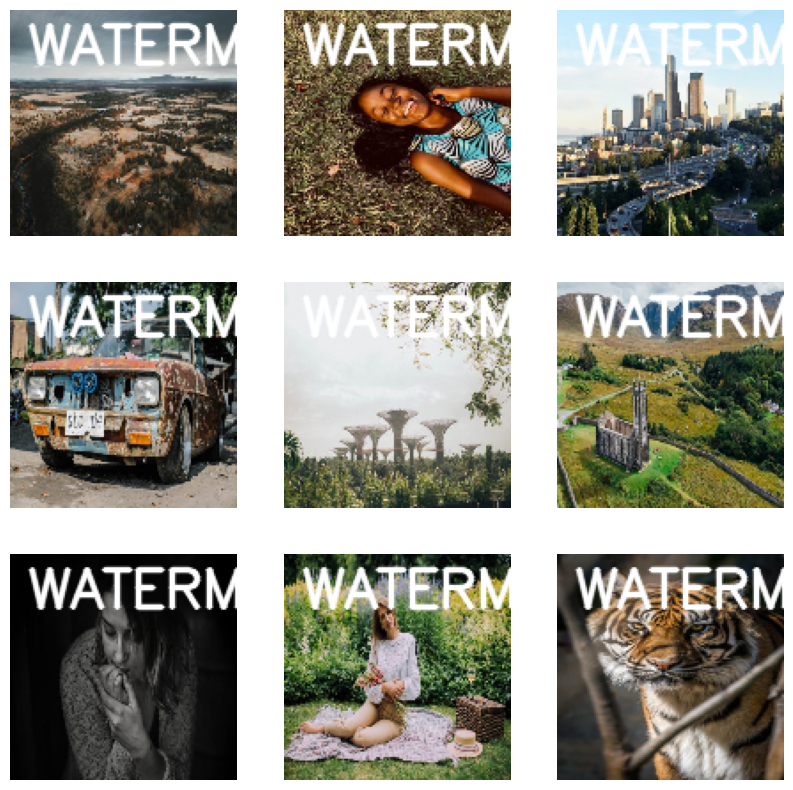

In [ ]:
# Функция для нанесения водяных знаков на изображения
def apply_watermark(image, text="WATERMARK", position=(10, 30)):
    image_with_watermark = image.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    color = (255, 255, 255)  # Белый цвет текста
    thickness = 2
    image_with_watermark = cv2.putText(image_with_watermark, text, position, font, font_scale, color, thickness, cv2.LINE_AA)
    return image_with_watermark

# Применение водяных знаков к обучающим и контрольным изображениям
X_train_watermarked = np.array([apply_watermark(img) for img in X_train])
X_valid_watermarked = np.array([apply_watermark(img) for img in X_valid])

# Визуализация примеров изображений с водяными знаками
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.cvtColor(X_train_watermarked[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()


In [ ]:
# Нормализация данных (приведение значений к диапазону [0, 1])
X_train = X_train.astype('float32') / 255.
X_train_watermarked = X_train_watermarked.astype('float32') / 255.
X_valid = X_valid.astype('float32') / 255.
X_valid_watermarked = X_valid_watermarked.astype('float32') / 255.

# Разделение данных на тренировочные и контрольные выборки
X_train, X_test, X_train_wm, X_test_wm = train_test_split(X_train, X_train_watermarked, test_size=0.2, random_state=42)


In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.optimizers import Adam

# Архитектура сверточного автокодировщика
def create_autoencoder():
    input_img = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))  # Цветные изображения

    # Кодировщик
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Декодировщик
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучение модели автокодировщика
history = autoencoder.fit(X_train_wm, X_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - loss: 0.6890 - val_loss: 0.6864
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.6823 - val_loss: 0.6789
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6758 - val_loss: 0.6687
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6631 - val_loss: 0.6520
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6460 - val_loss: 0.6272
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.6192 - val_loss: 0.5989
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.5924 - val_loss: 0.5822
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5776 - val_loss: 0.5742
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5754 - val_loss: 0.5651
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5668 - val_loss: 0.5590


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


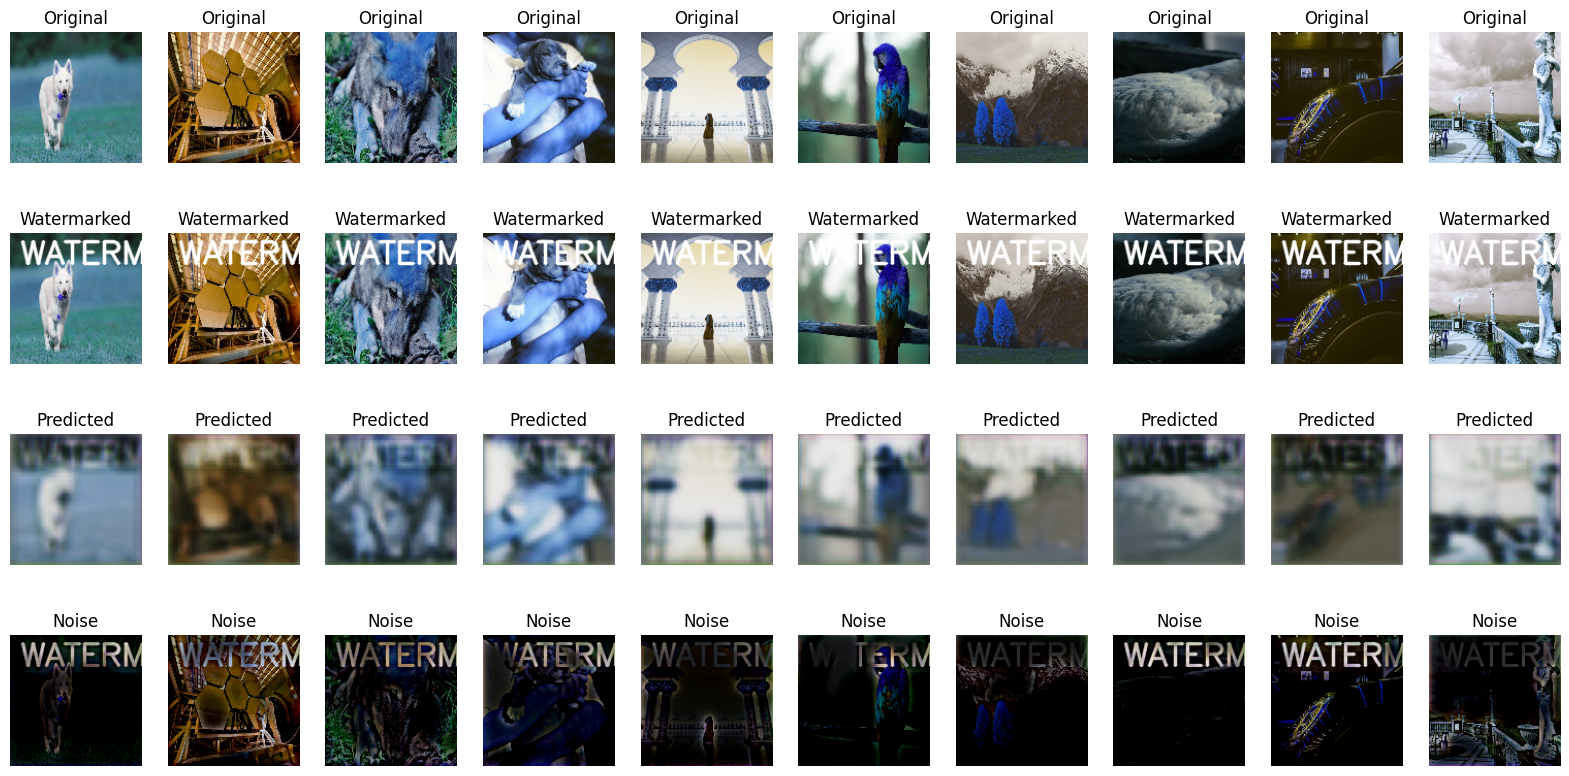

In [ ]:
# Предсказание на контрольной выборке
predicted = autoencoder.predict(X_test_wm)

# Визуализация результатов
n = 10
plt.figure(figsize=(20, 10))
for i in range(n):
    # Оригинальное изображение
    plt.subplot(4, n, i+1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis('off')

    # Изображение с водяным знаком
    plt.subplot(4, n, i+1+n)
    plt.imshow(X_test_wm[i])
    plt.title("Watermarked")
    plt.axis('off')

    # Предсказанное изображение
    plt.subplot(4, n, i+1+2*n)
    plt.imshow(predicted[i])
    plt.title("Predicted")
    plt.axis('off')

    # Шум (разница между предсказанным и исходным изображением)
    noise = X_test_wm[i] - predicted[i]
    plt.subplot(4, n, i+1+3*n)
    plt.imshow(noise)
    plt.title("Noise")
    plt.axis('off')
plt.show()
